In [1]:
import matplotlib.pyplot as plt, numpy as np, numpy.random as npr, csv, matplotlib.pyplot as plt
import torch.nn as nn, timeit, torch, pystan as ps
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import LocallyLinearEmbedding
from tqdm import trange
%matplotlib inline
from time import time
from pylab import plot, show, legend

In [3]:
sm = ps.StanModel(file="/home/postdoc/dsen/Desktop/codes/BNN_dimension_reduction/stan_files/nn_refpoints_constrainedtheta.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_cf61588642e0539b092dedc55e934141 NOW.


In [4]:
Y = np.load('Y_sphere.npy')
Nobs = np.shape(Y)[1]
print("Nobs =", Nobs)

Nobs = 628


### Local linear embedding for reference points:

In [49]:
n_ref = 40
lat_dim = 2
obs_dim = np.shape(Y)[0] 
ref_points = npr.choice(Nobs,n_ref,replace=False)
embedding = LocallyLinearEmbedding(n_components=lat_dim, n_neighbors=10)
Y_embedded = embedding.fit_transform(Y.transpose()).transpose()

In [50]:
train = np.setdiff1d(np.arange(Nobs), ref_points)
Y_ref = Y[:,ref_points]
X_ref = Y_embedded[:,ref_points]
Y_train = Y[:,train]

In [51]:
n_in = np.shape(Y_embedded)[0]
n_h = 10
n_out = np.shape(Y)[0]

model = nn.Sequential(nn.Linear(n_in, n_h), nn.Tanh(), nn.Linear(n_h, n_out))

In [52]:
def init_normal(m):
    if type(m) == nn.Linear: nn.init.normal_(m.weight)
model.apply(init_normal)
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3, momentum=0.9, nesterov=True)

In [53]:
n_iter = 100_000
Lss = np.zeros(n_iter)
start = time()
for epoch in range(n_iter):
    Y_pred = model(torch.from_numpy(X_ref.transpose().astype(np.float32)))
    loss = criterion(Y_pred, torch.from_numpy(Y_ref.transpose().astype(np.float32)))
    Lss[epoch] = loss.data
    if (epoch+1)%(n_iter/10) == 0 :
        print("Epoch: %d; loss: %.3f; time: %.1f mins" % (epoch+1, loss.item(), (time()-start)/60))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

Epoch: 10000; loss: 0.065; time: 0.0 mins
Epoch: 20000; loss: 0.064; time: 0.1 mins
Epoch: 30000; loss: 0.064; time: 0.1 mins
Epoch: 40000; loss: 0.063; time: 0.2 mins
Epoch: 50000; loss: 0.063; time: 0.2 mins
Epoch: 60000; loss: 0.063; time: 0.2 mins
Epoch: 70000; loss: 0.063; time: 0.3 mins
Epoch: 80000; loss: 0.062; time: 0.3 mins
Epoch: 90000; loss: 0.062; time: 0.3 mins
Epoch: 100000; loss: 0.062; time: 0.4 mins


In [54]:
for (i,p) in enumerate(model.parameters()):
    if i == 0 : W_1_optim = p.data;
    print(np.shape(p))

torch.Size([10, 2])
torch.Size([10])
torch.Size([3, 10])
torch.Size([3])


In [55]:
c = [np.linalg.norm(W_1_optim[i,:]) for i in range(n_in)]
for i in range(n_ref) : X_ref[:,i] *= c

In [56]:
data = dict(Nobs=Nobs, in_dim=n_in, out_dim=n_out, hidden_dim=n_h, n_ref=n_ref, X=Y_train, X_ref=Y_ref, Z_ref=X_ref)

### Run Stan:

In [57]:
# control = dict(adapt_delta=0.9, max_treedepth=12)
start = time()
fit = sm.sampling(data=data, thin=1, n_jobs=10, chains=10, init="random", iter=1_000)
print(round((time()-start)/60,2), "minutes to run")
print(fit);

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


36.45 minutes to run
Inference for Stan model: anon_model_cf61588642e0539b092dedc55e934141.
10 chains, each with iter=1000; warmup=500; thin=1; 
post-warmup draws per chain=500, total post-warmup draws=5000.

                     mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
Z[1,1]               0.48    0.11   0.62  -0.96   0.17   0.51   0.83   1.82     33   1.52
Z[2,1]               0.29    0.24   0.84  -1.79  -0.03   0.47   0.85   1.51     12   1.35
Z[3,1]               0.23    0.13    0.6  -1.03  -0.11   0.26   0.59    1.5     22    1.3
Z[4,1]               0.47    0.63   1.53  -2.45  -0.61   0.98   1.71   2.54      6   2.94
Z[5,1]               0.19     0.3   0.96  -1.99  -0.17   0.47   0.84   1.51     10   1.49
Z[6,1]            -4.6e-3    0.16   0.66  -1.24  -0.39  -0.07   0.33   1.55     17   1.23
Z[7,1]              -0.01     0.5    1.2  -2.32  -1.18   0.32   0.88   1.85      6   3.15
Z[8,1]              -0.59    0.17   0.59  -1.52  -1.01   -0.7  -0.28   

In [58]:
trace = fit.extract()
n_samples, n_latent = np.shape(trace['Z'])[0], np.shape(trace['Z'])[1]

#### Traceplots of latent variables:

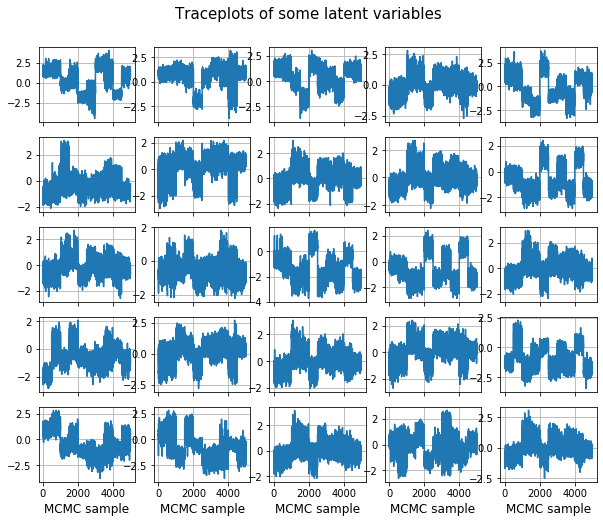

In [59]:
plt.figure(figsize=(10,8))
idx = npr.choice(n_latent,25).reshape(5,5)

for i in range(5):
    for j in range(5):
        k = 5*i+j
        plt.subplot(5,5,k+1)
        plt.plot(trace['Z'][:,idx[i,j],0])
        if i < 4 : plt.xticks(alpha=0)
        if i == 4 : plt.xlabel("MCMC sample", fontsize=12)
        plt.grid(True)
plt.suptitle("Traceplots of some latent variables", fontsize=15, x=0.5,y=0.95)
plt.show()

### Loss:

100%|██████████| 5000/5000 [00:00<00:00, 6589.22it/s]


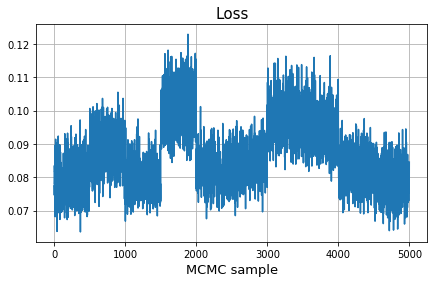

In [60]:
def L2_loss(X, Z, weights_1, bias_1, weights_2, bias_2) :
    X_pred = np.matmul(np.tanh(np.matmul(Z,weights_1)+bias_1), weights_2) + bias_2
    return np.mean(np.sum((X-X_pred)**2,axis=1))

loss = np.zeros(n_samples)
for i in trange(n_samples) :
    loss[i] = L2_loss(Y_train.transpose(), trace['Z'][i], trace['weights_1'][i], 
                      trace['bias_1'][i], trace['weights_2'][i], trace['bias_2'][i])
plt.figure(figsize=(7,4))
plt.plot(loss)
plt.title("Loss", fontsize=15)
plt.xlabel("MCMC sample", fontsize=13)
plt.grid(True)
# plt.savefig('/home/postdoc/dsen/Desktop/VAE_density/plots/loss_constrainedW1_refpoints.pdf', 
#             dpi=1000, bbox_inches='tight');

### Pairwise distances:

In [61]:
k_max = 50

pw_dist_matrix = np.zeros((n_latent,n_latent,n_samples))
for k in trange(n_samples) :
    for i in range(k_max) :
        for j in range(k_max) :
            pw_dist_matrix[i,j,k] = np.linalg.norm(trace['Z'][k,i]-trace['Z'][k,j])

100%|██████████| 5000/5000 [01:15<00:00, 66.53it/s]


Text(0.31, 0.83, 'Traceplots of some pairwise distances of latent variables for hypersphere')

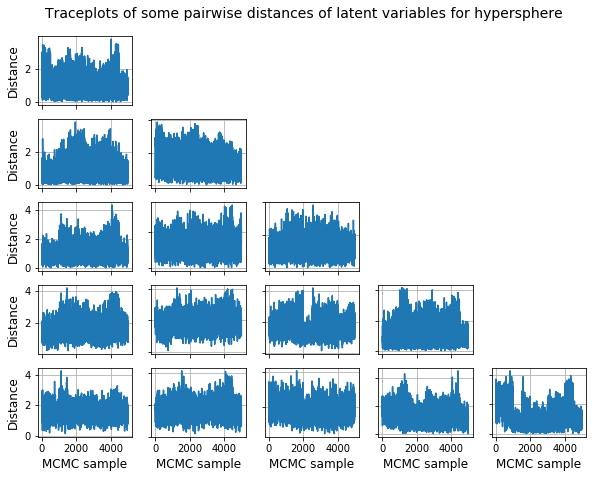

In [62]:
idx = npr.choice(k_max,10,replace=False)
plt.figure(figsize=(20,15))
for i in range(6):
    for j in range(6):
        if i > j :
            k = 10*i+j+1
            plt.subplot(10,10,k)
            plt.plot(pw_dist_matrix[idx[i],idx[j]])
            if i < 5 : plt.xticks(alpha=0)
            plt.grid(True)
            if i == 5 : plt.xlabel("MCMC sample", fontsize=12)
            if j > 0 : plt.yticks(alpha=0)
            if j == 0 : plt.ylabel("Distance", fontsize=12)
plt.suptitle("Traceplots of some pairwise distances of latent variables for hypersphere", fontsize=14, x=0.31,y=0.83)
# plt.savefig('/home/postdoc/dsen/Desktop/VAE_density/plots/sphere_pwdist_constrainedW1_refpoints.pdf', 
#                 dpi=2000, bbox_inches='tight');